In [103]:
#ALALA_Machine_Learning_Group_Project
#Names:
#1) Sai Vivek Kodam
#2) Humesh Reddy Venkatapuram
#3) Mohith Krishna Reddy D
#4) Olabisi Adebisi
# Crop yield Prediction Using Machine Learning Techniques

In [108]:
import os
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

from statsmodels.tsa.arima.model import ARIMA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB

from sklearn.svm import SVR


import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [85]:
if os.path.isfile("yield_df.csv"):
    yield_df = pd.read_csv("yield_df.csv")
else:
    pesticides_df = pd.read_csv("pesticides.csv")
    rainfall_df = pd.read_csv("rainfall.csv")
    temp_df = pd.read_csv("temp.csv")
    yielddf = pd.read_csv("yield.csv")

    pesticides_df = pesticides_df.drop(["Domain", "Element", "Item"], axis=1)
    pesticides_df = pesticides_df.rename(columns={"Area": "Country"})
    pesticides_df["Year"] = pesticides_df["Year"].astype(int)

    rainfall_df = rainfall_df.rename(
        columns={"average_rain_fall_mm_per_year": "Rainfall"}
    )
    rainfall_df = rainfall_df.rename(columns={" Area": "Country"})
    rainfall_df["Year"] = rainfall_df["Year"].astype(int)

    temp_df = temp_df.rename(
        columns={"year": "Year", "avg_temp": "Temperature", "country": "Country"}
    )
    temp_df["Year"] = temp_df["Year"].astype(int)

    yielddf = yielddf.drop(
        ["Domain Code", "Domain", "Element Code", "Item Code"], axis=1
    )
    yielddf = yielddf.rename(columns={"Area": "Country", "Value": "Yield"})
    yielddf["Year"] = yielddf["Year"].astype(int)

    yield_df = pd.merge(pesticides_df, rainfall_df, on=["Country", "Year"], how="outer")
    yield_df = pd.merge(yield_df, temp_df, on=["Country", "Year"], how="outer")
    yield_df = pd.merge(yield_df, yielddf, on=["Country", "Year"], how="outer")

    yield_df = yield_df.drop(["Unit_x", "Element", "Year Code", "Unit_y"], axis=1)
    yield_df = yield_df.dropna()

    yield_df.to_csv("yield_df.csv", index=False)

In [86]:
yield_df = yield_df.dropna(subset=["Yield"])
yield_df = yield_df[yield_df["Value"] > 0]
yield_df = yield_df[yield_df["Rainfall"] != "No Data"]
yield_df = yield_df[yield_df["Temperature"] != "No Data"]

yield_df["Rainfall"] = yield_df["Rainfall"].replace("..", np.nan)

# Replace non-numeric values with 0
yield_df["Rainfall"] = yield_df["Rainfall"].fillna(0)
yield_df["Rainfall"] = yield_df["Rainfall"].astype(int)
yield_df["Area Code"] = yield_df["Area Code"].astype(int)
yield_df["Temperature"] = yield_df["Temperature"].astype(float)

encoder = OneHotEncoder(sparse=False, handle_unknown="ignore")
cat_cols = ["Country", "Area Code", "Item"]
encoded_cols = pd.DataFrame(encoder.fit_transform(yield_df[cat_cols]))
encoded_cols.columns = encoder.get_feature_names_out(cat_cols)
yield_df_encoded = pd.concat([yield_df.drop(cat_cols, axis=1), encoded_cols], axis=1)
yield_df_encoded.head()

print(yield_df.dtypes)
# group the dataframe by 'Item' and 'Year' columns and calculate the mean of 'Yield' column
grouped_df = yield_df.groupby(["Item", "Year"]).mean().reset_index()

Country         object
Year             int64
Value          float64
Rainfall         int64
Temperature    float64
Area Code        int64
Item            object
Yield          float64
dtype: object


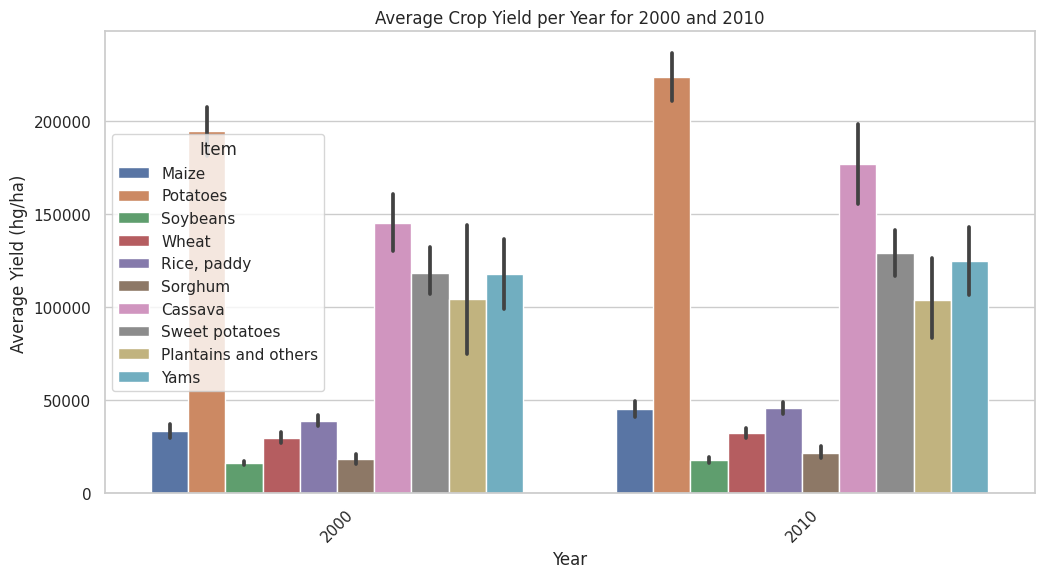

In [87]:
# Filter the data for specific years (e.g., 2000 and 2010)
years_to_plot = [2000, 2010]
filtered_df = yield_df[yield_df['Year'].isin(years_to_plot)]

# Set the style for Seaborn plots
sns.set(style="whitegrid")

# Plot the graph using Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x="Year", y="Yield", hue="Item", data=filtered_df)
plt.title("Average Crop Yield per Year for 2000 and 2010")
plt.xlabel("Year")
plt.ylabel("Average Yield (hg/ha)")
plt.xticks(rotation=45)
plt.show()

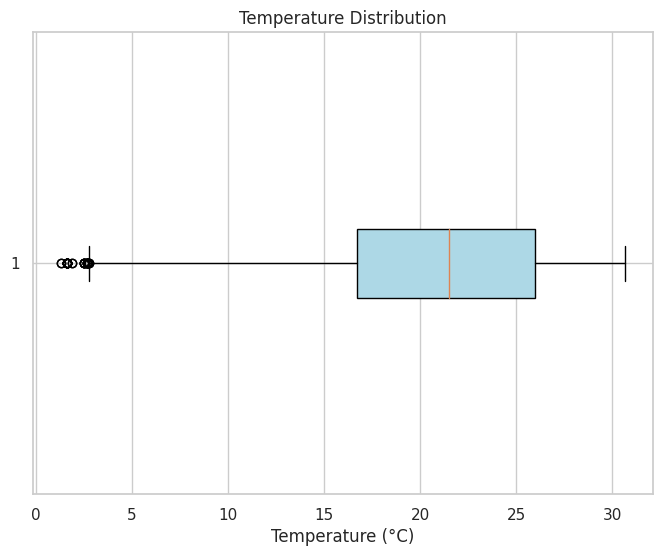

In [88]:
# Box Plot to Visualize Temperature Distribution
plt.figure(figsize=(8, 6))
plt.boxplot(yield_df['Temperature'], vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title('Temperature Distribution')
plt.xlabel('Temperature (°C)')
plt.grid(True)
plt.show()

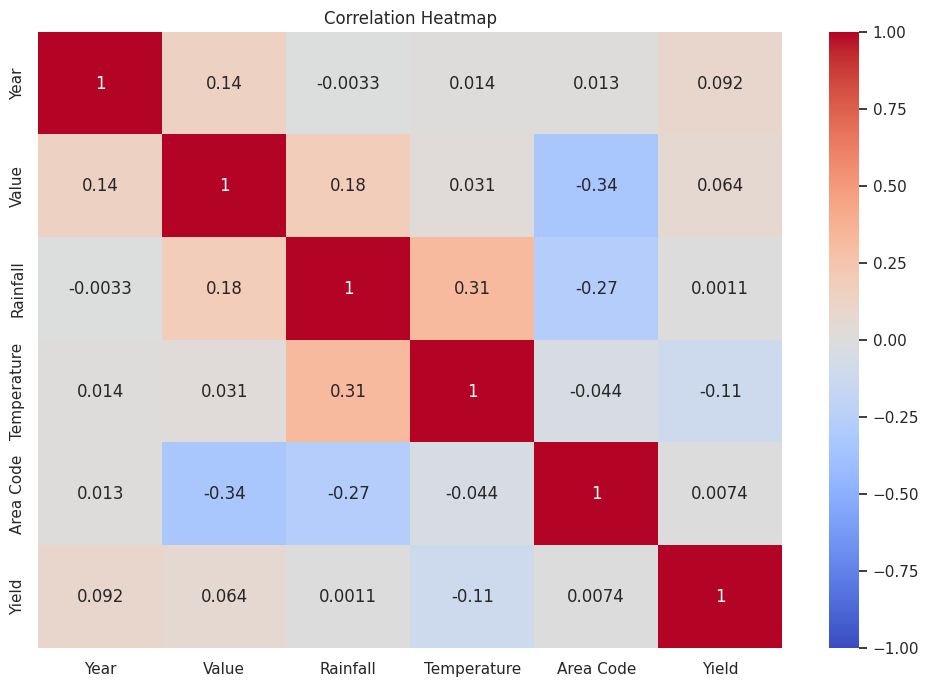

In [89]:
# plot the correlation heatmap using seaborn library
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
sns.heatmap(yield_df.corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

In [105]:
# Rename columns for consistent merging
pesticides_df = pesticides_df.rename(columns={"Area": "Country"})
rainfall_df = rainfall_df.rename(columns={" Area": "Country"})
temp_df = temp_df.rename(columns={"year": "Year", "country": "Country"})

# Merge datasets using correct column names
merged_df = yield_df.rename(columns={"Area": "Country"}).merge(pesticides_df[['Country', 'Year', 'Value']], how='left', on=['Country', 'Year'], suffixes=('', '_pesticides'))
merged_df = merged_df.merge(rainfall_df[['Country', 'Year', 'average_rain_fall_mm_per_year']], how='left', on=['Country', 'Year'])
merged_df = merged_df.merge(temp_df[['Country', 'Year', 'avg_temp']], how='left', on=['Country', 'Year'])

# Continue with the rest of the code...

# One-hot encode categorical variables 'Country' and 'Item'
merged_df_encoded = pd.get_dummies(merged_df, columns=['Country', 'Item'])

# Convert other columns to appropriate data types and fill NaN
merged_df_encoded = merged_df_encoded.apply(pd.to_numeric, errors='coerce')
merged_df_encoded.fillna(merged_df_encoded.median(), inplace=True)

# Extract the relevant columns for scaling and model training
relevant_columns = ['Value_pesticides', 'avg_temp']
X_relevant = merged_df_encoded[relevant_columns]
y_relevant = merged_df_encoded['Value']  # Change 'Yield' to 'Value'

# Continue with the rest of the code...

In [90]:
### Training , Testing Data (Holdout) ####

# Split data into train and test sets
X = yield_df_encoded.drop(["Yield"], axis=1)
y = yield_df_encoded["Yield"]
X_train_holdout, X_test_holdout, y_train_holdout, y_test_holdout = train_test_split(
    X, y, test_size=0.3, random_state=42)


# Define the number of splits for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Convert X and y to numpy arrays for compatibility with KFold
X_v, y_v = X.values, y.values

# Initialize lists to store data for each fold
X_train_cross_list, X_test_cross_list = [], []
y_train_cross_list, y_test_cross_list = [], []

# Perform 5-fold cross-validation
for train_index, test_index in kf.split(X_v):
    X_train_cross, X_test_cross = X_v[train_index], X_v[test_index]  # Training and testing data for independent variables
    y_train_cross, y_test_cross = y_v[train_index], y_v[test_index]  # Training and testing data for dependent variable

    # Append the data for this fold to the lists
    X_train_cross_list.append(X_train_cross)
    X_test_cross_list.append(X_test_cross)
    y_train_cross_list.append(y_train_cross)
    y_test_cross_list.append(y_test_cross)

In [91]:
def runtime_model_prediction_(model, X_train, y_train, X_test):
    start = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    end = time.time()
    runtime = end - start
    return model, y_pred, runtime

def get_analysis(X, y, models, X_train, y_train, X_test, y_test):
    results = []

    for model, model_name in models:
        clf, y_pred, runtime = runtime_model_prediction_(model, X_train, y_train, X_test)
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)

        results.append({
            'Model': model_name,
            'R-squared': r2,
            'Mean Squared Error': mse,
            'Runtime (seconds)': runtime
        })

        print(f"Time took for {model_name}: {runtime:.3f} seconds")
        print(f"{model_name} R-squared score: {r2}")
        print(f"{model_name} Mean squared error: {mse}\n")

    return results

In [92]:
# Create dataframe for visualization

def create_df_vis(X_test,y_test,X,y_pred,y_pred1,y_pred2,y_pred3):
  df_test = pd.DataFrame(X_test, columns=X.columns).copy(deep = True)
  df_test["prediction_yield"] = y_pred
  df_test["prediction_yield1"] = y_pred1
  df_test["prediction_yield2"] = y_pred2
  df_test["prediction_yield3"] = y_pred3
  df_test["actual_yield"] = y_test.tolist()
  return df_test

In [93]:
# Create instances of the models with names
lasso_model = (Lasso(alpha=1.0), "Lasso")
rf_model = (RandomForestRegressor(n_estimators=100), "Random Forest")
knn_model = (KNeighborsRegressor(n_neighbors=5), "KNN")
gb_model = (GradientBoostingRegressor(n_estimators=100), "Gradient Boosting")

# Create a list of models to evaluate
models_to_evaluate = [lasso_model, rf_model, knn_model, gb_model]

# Perform analysis
results = get_analysis(X, y, models_to_evaluate, X_train_holdout, y_train_holdout, X_test_holdout, y_test_holdout)

# Display results
results_df = pd.DataFrame(results)
print(results_df)

Time took for Lasso: 6.829 seconds
Lasso R-squared score: 0.7507330782449312
Lasso Mean squared error: 1803388475.0932772

Time took for Random Forest: 23.796 seconds
Random Forest R-squared score: 0.9872916494290346
Random Forest Mean squared error: 91941974.47362693

Time took for KNN: 3.524 seconds
KNN R-squared score: 0.35825691877601684
KNN Mean squared error: 4642862632.962436

Time took for Gradient Boosting: 9.668 seconds
Gradient Boosting R-squared score: 0.8718975053378408
Gradient Boosting Mean squared error: 926791893.9177825

               Model  R-squared  Mean Squared Error  Runtime (seconds)
0              Lasso   0.750733        1.803388e+09           6.828503
1      Random Forest   0.987292        9.194197e+07          23.795946
2                KNN   0.358257        4.642863e+09           3.524463
3  Gradient Boosting   0.871898        9.267919e+08           9.667840


In [94]:
# Perform analysis
results = get_analysis(X, y, models_to_evaluate, X_train_cross, y_train_cross, X_test_cross, y_test_cross)

# Display results
results_df = pd.DataFrame(results)
print(results_df)

Time took for Lasso: 9.089 seconds
Lasso R-squared score: 0.7554218617600666
Lasso Mean squared error: 1712823411.546339

Time took for Random Forest: 34.555 seconds
Random Forest R-squared score: 0.9876949843253561
Random Forest Mean squared error: 86174173.5326264

Time took for KNN: 2.154 seconds
KNN R-squared score: 0.363787828189606
KNN Mean squared error: 4455504937.724894

Time took for Gradient Boosting: 16.258 seconds
Gradient Boosting R-squared score: 0.8678345284453336
Gradient Boosting Mean squared error: 925577876.6899325

               Model  R-squared  Mean Squared Error  Runtime (seconds)
0              Lasso   0.755422        1.712823e+09           9.089011
1      Random Forest   0.987695        8.617417e+07          34.554710
2                KNN   0.363788        4.455505e+09           2.153892
3  Gradient Boosting   0.867835        9.255779e+08          16.257824


In [95]:
# Create a list of models to evaluate
models_to_evaluate = [lasso_model, rf_model, knn_model, gb_model]

# Initialize a dictionary to store predictions for each model
all_predictions = {}

# Iterate through the list of models and make predictions
for model, model_name in models_to_evaluate:
    y_pred = model.predict(subset_X_test)  # Make predictions on the subset of data
    all_predictions[model_name] = y_pred  # Store predictions in the dictionary

# Create a DataFrame to display actual and predicted values for all models
all_predictions_df = pd.DataFrame({'Actual Yield': subset_y_test})
for model_name, predictions in all_predictions.items():
    all_predictions_df[f'Predicted Yield ({model_name})'] = predictions

print(all_predictions_df)

       Actual Yield  Predicted Yield (Lasso)  Predicted Yield (Random Forest)  \
18798       45266.0            -10587.022038                         43447.77   
26337       32884.0             15509.753477                         31923.15   
7125        19295.0            -22279.567130                         20798.20   
16581       24000.0             82560.727957                         24023.62   
20367      268098.0            217728.770422                        268198.13   
10193      114676.0            153687.021979                        122249.93   
6952        84888.0            181757.960306                         89034.80   
3498        23724.0              -247.900894                         23722.09   
2041        60000.0             -2674.385884                         54770.45   
10664        8136.0             16094.034599                          8136.00   

       Predicted Yield (KNN)  Predicted Yield (Gradient Boosting)  
18798                30481.2            

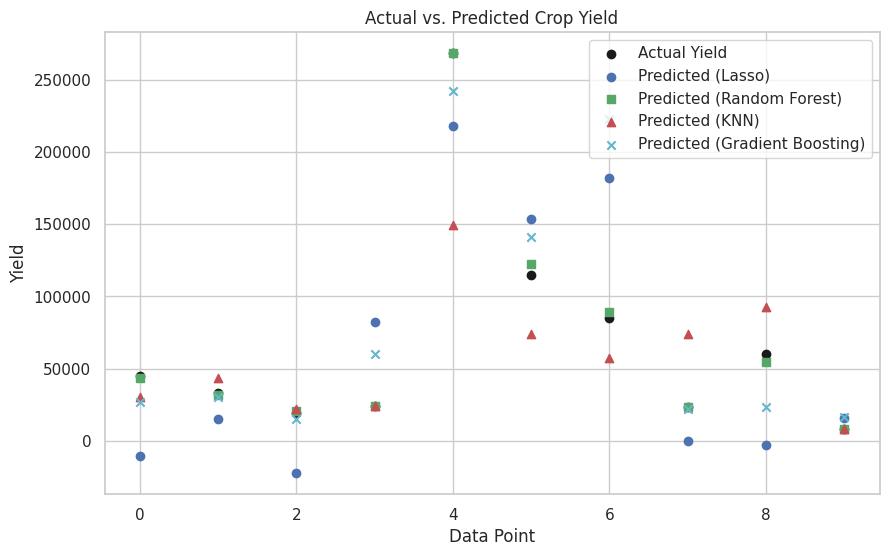

In [96]:
# Create a list of markers and colors for each model
markers = ['o', 's', '^', 'x']
colors = ['b', 'g', 'r', 'c']

# Initialize a figure and axis for the plot
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Plot actual values
plt.scatter(range(len(subset_y_test)), subset_y_test, c='k', label='Actual Yield', marker='o')

# Iterate through the list of models and plot their predicted values with different colors and markers
for i, (model, model_name) in enumerate(models_to_evaluate):
    predictions = all_predictions[model_name]
    plt.scatter(range(len(predictions)), predictions, c=colors[i], label=f'Predicted ({model_name})', marker=markers[i])

# Customize the plot
plt.title('Actual vs. Predicted Crop Yield')
plt.xlabel('Data Point')
plt.ylabel('Yield')
plt.legend(loc='upper right')

# Show the plot
plt.show()

In [97]:
# Calculate the average yield for each crop over the years
average_yield_by_crop = yield_df.groupby('Item')['Yield'].mean().reset_index()

# Sort crops by average yield in descending order
best_crops = average_yield_by_crop.sort_values(by='Yield', ascending=False)

# Print the top N crops with the highest average yield
top_n_crops = 10  # Change this number as needed
print(f"Top {top_n_crops} crops with the highest average yield:")
print(best_crops.head(top_n_crops))

Top 10 crops with the highest average yield:
                   Item          Yield
3              Potatoes  199801.549579
0               Cassava  150433.403517
7        Sweet potatoes  118999.490664
9                  Yams  114140.345927
2  Plantains and others  106041.320144
4           Rice, paddy   40730.434770
1                 Maize   36300.137764
8                 Wheat   30116.267825
5               Sorghum   18635.777229
6              Soybeans   16731.092771


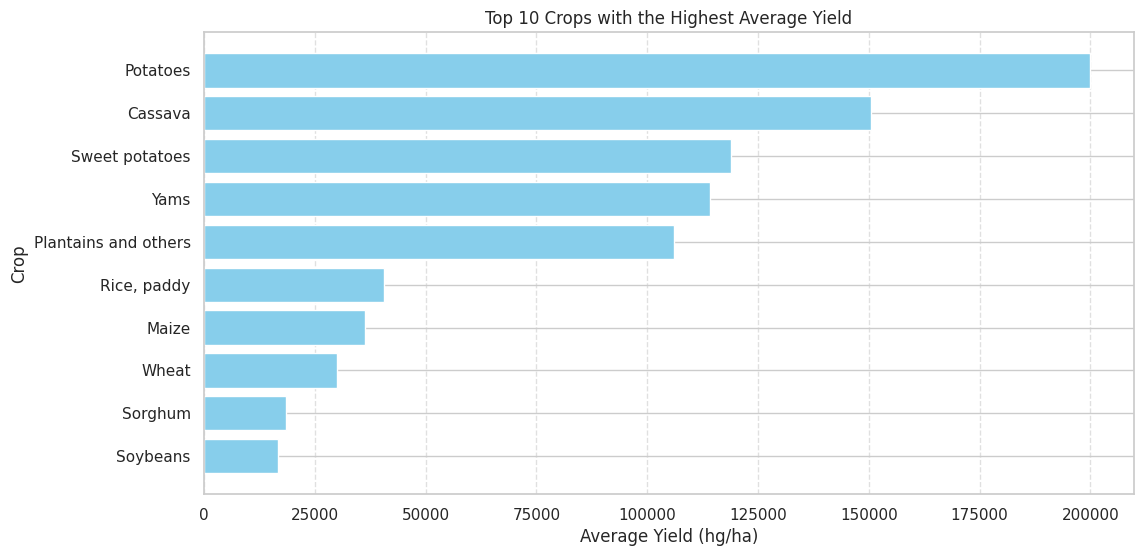

In [101]:
# Create a bar plot
plt.figure(figsize=(12, 6))
plt.barh(top_crops['Item'], top_crops['Yield'], color='skyblue')
plt.title(f'Top {top_n_crops} Crops with the Highest Average Yield')
plt.xlabel('Average Yield (hg/ha)')
plt.ylabel('Crop')
plt.gca().invert_yaxis()  # Invert the y-axis to show the highest yield at the top
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

In [106]:
# Initialize and fit the scaler on the relevant columns
scaler = StandardScaler()
X_relevant_scaled = scaler.fit_transform(X_relevant)

# Train the Random Forest model using the scaled relevant columns
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_model.fit(X_relevant_scaled, y_relevant)

# Group by Year and get the mean for each variable
grouped_data = merged_df.groupby('Year').mean()

# Forecasting function using ARIMA
def forecast_with_arima(data, column_name, order=(5,1,0), steps=10):
    array_data = data[column_name].values
    model = ARIMA(array_data, order=order)
    result = model.fit()
    return result.forecast(steps=steps)

# Forecast for the years 2022 to 2034
forecasted_years = list(range(2022, 2035))

# Create the future data DataFrame
future_data = pd.DataFrame({
    'Value_pesticides': forecast_with_arima(grouped_data, 'Value_pesticides', steps=13),
    'avg_temp': forecast_with_arima(grouped_data, 'avg_temp', steps=13)
}, index=forecasted_years)

# Scale the future data using the scaler
future_data_scaled = scaler.transform(future_data)

# Predict the crop yield using Random Forest for the years 2022 to 2034
predicted_yield_2022_2034 = rf_model.predict(future_data_scaled)

# Create a DataFrame for better visualization
predicted_yield_df_2022_2034 = pd.DataFrame({
    'Year': forecasted_years,
    'Predicted Yield': predicted_yield_2022_2034
})

print(predicted_yield_df_2022_2034)

    Year  Predicted Yield
0   2022       82443.3512
1   2023       83810.0000
2   2024       84312.7800
3   2025       84154.5978
4   2026       84117.0000
5   2027       84117.0000
6   2028       84154.5978
7   2029       84154.5978
8   2030       84154.5978
9   2031       84154.5978
10  2032       84154.5978
11  2033       84154.5978
12  2034       84154.5978


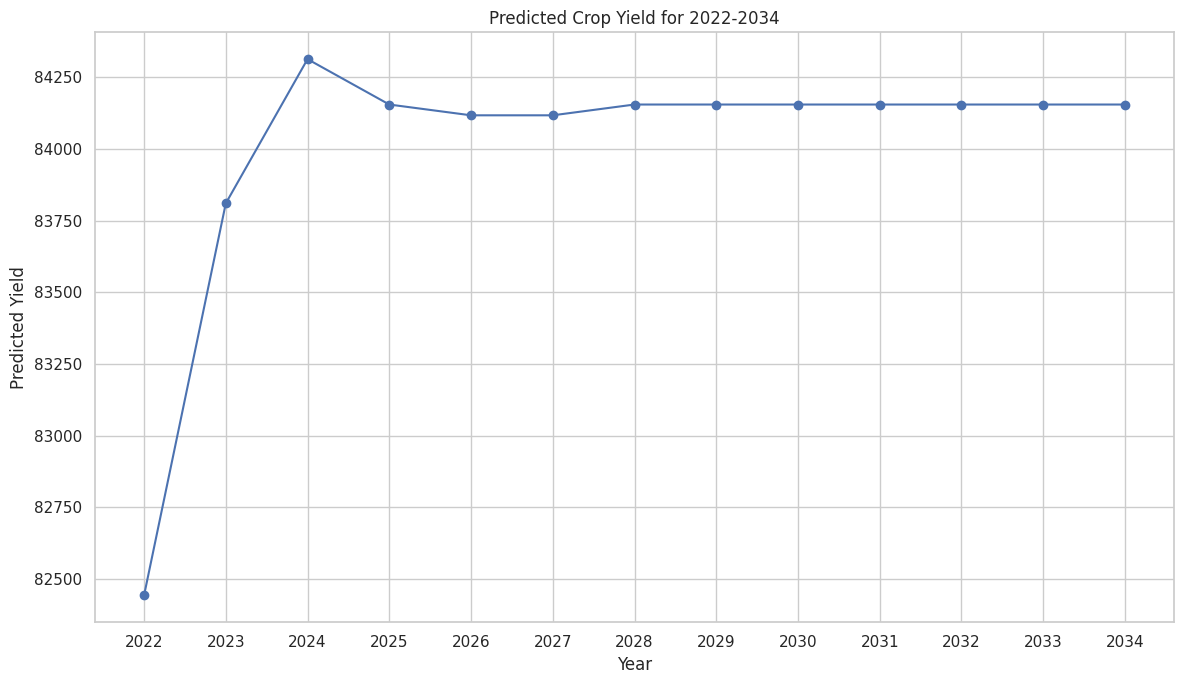

In [107]:
# Data
years = predicted_yield_df_2022_2034['Year']
yield_values = predicted_yield_df_2022_2034['Predicted Yield']

# Plotting
plt.figure(figsize=(12, 7))
plt.plot(years, yield_values, marker='o', linestyle='-', color='b')
plt.title('Predicted Crop Yield for 2022-2034')
plt.xlabel('Year')
plt.ylabel('Predicted Yield')
plt.grid(True)
plt.xticks(years)  # This line sets the x-ticks to only the years in your data
plt.tight_layout()
plt.show()